# 1. Seq2Seq (Only RNN)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import time
import re
from unidecode import unidecode

In [2]:
file_path = 'C:/Users/Myeong/dding/data/nmt_attention/spa-eng/spa.txt'

all_data = pd.read_csv(file_path, names=['en', 'sp', 'cc'], sep='\t')
all_data

,en,sp,cc
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
139008,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
139009,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
139010,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
139011,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
def preprocess_sentence(s):
    s = unidecode(s)
    s = s.lower().strip()
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)
    s = s.strip()
    s = '<start> ' + s + ' <end>'
    return s

data = all_data[['en', 'sp']][110000:]
data['pre_en'] = data['en'].apply(preprocess_sentence)
data['pre_sp'] = data['sp'].apply(preprocess_sentence)
data

,en,sp,pre_en,pre_sp
110000,I've already finished reading this book.,Ya me he acabado este libro.,<start> i ve already finished reading this boo...,<start> ya me he acabado este libro . <end>
110001,I've always thought you were a Canadian.,Siempre he pensado que eras canadiense.,<start> i ve always thought you were a canadia...,<start> siempre he pensado que eras canadiense...
110002,I've always wanted to learn how to swim.,Siempre he querido aprender a nadar.,<start> i ve always wanted to learn how to swi...,<start> siempre he querido aprender a nadar . ...
110003,I've always wanted to play the trombone.,Siempre he querido tocar el trombón.,<start> i ve always wanted to play the trombon...,<start> siempre he querido tocar el trombon . ...
110004,I've been able to read since I was five.,He podido leer desde que tenía cinco años.,<start> i ve been able to read since i was fiv...,<start> he podido leer desde que tenia cinco a...
...,...,...,...,...
139008,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...,<start> a carbon footprint is the amount of ca...,<start> una huella de carbono es la cantidad d...
139009,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...,<start> since there are usually multiple websi...,<start> como suele haber varias paginas web so...
139010,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe...",<start> if you want to sound like a native spe...,<start> si quieres sonar como un hablante nati...
139011,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...,<start> it may be impossible to get a complete...,<start> puede que sea imposible obtener un cor...


In [4]:
def tokenize(lang):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(lang)

    tensor = tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

def load_dataset(data):
    input_sentence = data['pre_sp']
    output_sentence = data['pre_en']

    input_tensor, input_tokenizer = tokenize(input_sentence)
    output_tensor, output_tokenizer = tokenize(output_sentence)

    return input_tensor, input_tokenizer, output_tensor, output_tokenizer

sp_tensor, sp_tokenizer, en_tensor, en_tokenizer = load_dataset(data)

In [5]:
max_input_len, max_target_len = sp_tensor.shape[1], en_tensor.shape[1]
print(max_input_len ,max_target_len)

80 83


In [6]:
sp_vocab_size = len(sp_tokenizer.word_index) + 1
en_vocab_size = len(en_tokenizer.word_index) + 1
print(en_vocab_size, sp_vocab_size)


9832 16466


In [7]:
# encoder input, decoder input, decoder output 정의
encoder_input = sp_tensor

decoder_input = np.array([[char for char in line if char != en_tokenizer.word_index['<end>']] for line in en_tensor]) # '<end>' 토큰의 번호가 3이기 때문에 삭제
decoder_output = np.array([[char for char in line if char != en_tokenizer.word_index['<start>']] for line in en_tensor]) # '<start>' 토큰의 번호가 2이기 때문에 삭제

print(np.shape(encoder_input))
print(np.shape(decoder_input))
print(np.shape(decoder_output))
print(decoder_input[:2])
print(decoder_output[:2])

(29013, 80)
(29013, 82)
(29013, 82)
[[   1    6   75  253  398  390   25  185    3    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1    6   75  125  100    7   67    8 1237    3    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
[[   6   75  253  398  390   25  185    3    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    

In [8]:
n_of_val = 1000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_output_train = decoder_output[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_output_test = decoder_output[-n_of_val:]

print('스페인어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('영어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('영어 학습 출력데이터의 크기(shape) :',np.shape(decoder_output_train))

print('스페인어 Valid 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('영어 Valid 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('영어 Valid 출력데이터의 크기(shape) :',np.shape(decoder_output_test))

스페인어 학습데이터의 크기(shape) : (28013, 80)
영어 학습 입력데이터의 크기(shape) : (28013, 82)
영어 학습 출력데이터의 크기(shape) : (28013, 82)
스페인어 Valid 데이터의 크기(shape) : (1000, 80)
영어 Valid 입력데이터의 크기(shape) : (1000, 82)
영어 Valid 출력데이터의 크기(shape) : (1000, 82)


In [9]:
# 모델 훈련
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_dim = 256
hidden_units = 1024

encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(sp_vocab_size, embedding_dim, input_length=max_input_len)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(en_vocab_size, embedding_dim)
dec_emb_layer = dec_emb(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb_layer, initial_state=encoder_states)

decoder_dense = Dense(en_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    4215296     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2516992     ['input_2[0][0]']                
                                                                                              

In [10]:

model.fit(x = [encoder_input_train, decoder_input_train],
          y = decoder_output_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test),
          batch_size=64,
          epochs=10,
          )

Epoch 1/10
438/438 [==============================] - 24s 46ms/step - loss: 1.0339 - val_loss: 1.5276
Epoch 2/10
 77/438 [====>.........................] - ETA: 15s - loss: 0.7000

KeyboardInterrupt: 

In [11]:
# 번역 모델 구현
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb_layer, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [12]:
sp2idx = sp_tokenizer.word_index
en2idx = en_tokenizer.word_index
idx2sp = sp_tokenizer.index_word
idx2en = en_tokenizer.index_word

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq, verbose=0)

    target_seq = np.zeros((1,1))
    target_seq[0,0] = en2idx['<start>']

    stop_condition = False
    decoded_sentence = ''
    decoded_len = 1
    
    # stop_condition=True가 될 때까지 반복
    # 배치 사이즈는 1로 가정
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq]+states_value, verbose=0)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2en[sampled_token_index]

        # <end> 토큰에 도달하거나 정해진 길이를 넘으면 중단
        if (sampled_char == '<end>' or decoded_len > max_target_len):
            break

        # 현재 시점 예측 단어 문장에 추가
        decoded_sentence = decoded_sentence + ' ' + sampled_char
        decoded_len += 1

        
        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index

        states_value = [h, c]
    
    return decoded_sentence

In [13]:
# 원문의 정수 시퀀스를 텍스트로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if encoded_word != 0:
            sentence = sentence + idx2sp[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if encoded_word != 0 and encoded_word != en2idx['<start>'] and encoded_word != en2idx['<end>']:
            sentence = sentence + idx2en[encoded_word] + ' '
    return sentence

In [14]:
for seq_index in [1000, 5000, 10000, 20000, 25000]:
    input_seq = encoder_input_train[seq_index: seq_index+1]
    decoded_sentence = decode_sequence(input_seq)

    print('입력 문장 : ', seq_to_src(encoder_input_train[seq_index]))
    print('정답 문장 : ', seq_to_tar(decoder_input_train[seq_index]))
    print('번역 문장 : ', decoded_sentence[1:])
    print('-'*50)

입력 문장 :  <start> tom siempre se esta quejando de su trabajo . <end> 
정답 문장 :  tom is always complaining about his job . 
번역 문장 :  tom has a lot of problems with mary .
--------------------------------------------------
입력 문장 :  <start> la mama se quedo en el coche mientras papa iba de compras . <end> 
정답 문장 :  mom remained in the car while dad shopped . 
번역 문장 :  the old man was seated on the bed reading magic .
--------------------------------------------------
입력 문장 :  <start> por lo general , vale la pena jugar el juego de la vida . <end> 
정답 문장 :  as a rule , the game of life is worth playing . 
번역 문장 :  in the beginning god created the heaven and the earth .
--------------------------------------------------
입력 문장 :  <start> para ser sincero , no me gusta su forma de pensar . <end> 
정답 문장 :  to tell the truth , i don t like his way of thinking . 
번역 문장 :  it s not good to force you to help us with her homework .
--------------------------------------------------
입력 문장 :  <start> l

# 2. Seq2Seq with Attention

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

import numpy as np
import pandas as pd
import time
import re
from unidecode import unidecode

In [2]:
file_path = 'C:/Users/Myeong/dding/data/nmt_attention/spa-eng/spa.txt'

all_data = pd.read_csv(file_path, names=['en', 'sp', 'cc'], sep='\t')
all_data

,en,sp,cc
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
139008,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
139009,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
139010,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...
139011,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [3]:
def preprocess_sentence(s):
    s = unidecode(s)
    s = s.lower().strip()
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    s = re.sub(r"[^a-zA-Z?.!,¿]+", " ", s)
    s = s.strip()
    s = '<start> ' + s + ' <end>'
    return s

data = all_data[['en', 'sp']][110000:]
data['pre_en'] = data['en'].apply(preprocess_sentence)
data['pre_sp'] = data['sp'].apply(preprocess_sentence)
data

,en,sp,pre_en,pre_sp
110000,I've already finished reading this book.,Ya me he acabado este libro.,<start> i ve already finished reading this boo...,<start> ya me he acabado este libro . <end>
110001,I've always thought you were a Canadian.,Siempre he pensado que eras canadiense.,<start> i ve always thought you were a canadia...,<start> siempre he pensado que eras canadiense...
110002,I've always wanted to learn how to swim.,Siempre he querido aprender a nadar.,<start> i ve always wanted to learn how to swi...,<start> siempre he querido aprender a nadar . ...
110003,I've always wanted to play the trombone.,Siempre he querido tocar el trombón.,<start> i ve always wanted to play the trombon...,<start> siempre he querido tocar el trombon . ...
110004,I've been able to read since I was five.,He podido leer desde que tenía cinco años.,<start> i ve been able to read since i was fiv...,<start> he podido leer desde que tenia cinco a...
...,...,...,...,...
139008,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...,<start> a carbon footprint is the amount of ca...,<start> una huella de carbono es la cantidad d...
139009,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...,<start> since there are usually multiple websi...,<start> como suele haber varias paginas web so...
139010,"If you want to sound like a native speaker, yo...","Si quieres sonar como un hablante nativo, debe...",<start> if you want to sound like a native spe...,<start> si quieres sonar como un hablante nati...
139011,It may be impossible to get a completely error...,Puede que sea imposible obtener un corpus comp...,<start> it may be impossible to get a complete...,<start> puede que sea imposible obtener un cor...


In [4]:
def tokenize(lang):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(lang)

    tensor = tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    return tensor, tokenizer

def load_dataset(data):
    input_sentence = data['pre_sp']
    output_sentence = data['pre_en']

    input_tensor, input_tokenizer = tokenize(input_sentence)
    output_tensor, output_tokenizer = tokenize(output_sentence)

    return input_tensor, input_tokenizer, output_tensor, output_tokenizer

input_tensor, input_tokenizer, target_tensor, target_tokenizer = load_dataset(data)

In [5]:
max_input_len, max_target_len = input_tensor.shape[1], target_tensor.shape[1]
print(max_input_len ,max_target_len)

80 83


In [6]:
target_tensor.shape

(29013, 83)

In [7]:
from sklearn.model_selection import train_test_split

# 훈련 인코더 데이터, 훈련 디코더 데이터, 테스트 인코더 데이터, 테스트 디코더 데이터
train_x, train_y, target_x, target_y = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(train_x.shape)
print(target_x.shape)
print(train_y.shape)
print(target_y.shape)

(23210, 80)
(23210, 83)
(5803, 80)
(5803, 83)


In [8]:
en2idx = input_tokenizer.word_index
idx2en = input_tokenizer.index_word

sp2idx = target_tokenizer.word_index
idx2sp = target_tokenizer.index_word

# tf.data 데이터셋 생성하기
BUFFER_SIZE = len(train_x)
BATCH_SIZE = 64
steps_per_epochs = len(train_x) // BATCH_SIZE
embedding_dim = 256
units = 1024

input_vocab_size = len(input_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((train_x, target_x)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [9]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 80]), TensorShape([64, 83]))

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state = True,
                                       recurrent_initializer = 'glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))
    

- query : 영향을 받는 단어를 나타내는 변수
- key : 영향을 주는 단어를 나타내는 변수
- value : 그 영향에 대한 가중치

In [11]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1628536276821275339
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9894363136
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9285791763504133768
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [12]:
# BahdanauAttention
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w1 = tf.keras.layers.Dense(units)
        self.w2 = tf.keras.layers.Dense(units)
        self.v = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape : (batch_size, hidden_size)
        # query_with_time_axis shape : (batch_size, 1, hidden_size)
        # values shape : (batch_size, max_len, hidden_size)
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape : (batch_size, max_length, 1)
        # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻는다.
        # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units) 쌍으로 이루어짐.
        score = self.v(tf.nn.tanh(
            self.w1(query_with_time_axis) + self.w2(values)
        ))

        # attention_weights shape : (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # 덧셈 이후 context vector shape : (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # use attention
        self.attention = BahdanauAttention(self.dec_units)
    
    def call(self, x, hidden, enc_output):
        # enc_output shape : (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 임베딩 후 x shape (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # context vector와 embedding 결과를 결합한 x shape : (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # x를 GRU에 전달
        output, state = self.gru(x)

        # output shape : (batch_size, 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape : (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights
    

In [14]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    # tf.math.equal : real의 값이 0이면 True, 아니면 False
    # tf.math.logical_not : True는 False로, False는 True로 바꿈
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## 훈련 과정
1. encoder input을 Encoder에 입력으로 넣고 encoder output, encoder hidden state를 얻는다.

2. encoder output, encoder hidden state를 Decoder로 전달한다.

3. 전달 받은 값을 통해 Decoder는 예측 값과 decoder hidden state를 반환한다.

4. decoder hidden state가 모델에 전달되고 loss를 계산한다.

5. decoder의 다음 입력을 위해 교사 강요(teacher forcing)를 사용한다.

6. 최적화를 진행한다.

In [15]:
encoder = Encoder(input_vocab_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(target_vocab_size, embedding_dim, units, BATCH_SIZE)

In [16]:
@tf.function
def train_step(input, target, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(input, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']]*BATCH_SIZE, 1)

        # teacher forcing
        for t in range(1, target.shape[1]):
            # enc_output을 디코더에 전달
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(target[:, t], predictions)

            # teacher forcing
            dec_input = tf.expand_dims(target[:, t], 1)
    
    batch_loss = (loss / int(target.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [17]:
EPOCHS = 10
from tqdm import tqdm

for epoch in tqdm(range(EPOCHS)):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (input, target)) in (enumerate(dataset.take(steps_per_epochs))):
        batch_loss = train_step(input, target, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
    print(f"Epoch {epoch + 1} Loss {(total_loss / steps_per_epochs):.4f}")
    print(f"Time taken for 1 epoch {time.time() - start} sec\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 1.3447
Epoch 1 Batch 100 Loss 0.8376
Epoch 1 Batch 200 Loss 0.7321
Epoch 1 Batch 300 Loss 0.6859


 10%|█         | 1/10 [03:25<30:50, 205.58s/it]

Epoch 1 Loss 0.7770
Time taken for 1 epoch 205.57604813575745 sec

Epoch 2 Batch 0 Loss 0.5961
Epoch 2 Batch 100 Loss 0.6412
Epoch 2 Batch 200 Loss 0.5863
Epoch 2 Batch 300 Loss 0.5623


 20%|██        | 2/10 [05:39<21:49, 163.64s/it]

Epoch 2 Loss 0.6078
Time taken for 1 epoch 134.27659392356873 sec

Epoch 3 Batch 0 Loss 0.5214
Epoch 3 Batch 100 Loss 0.5496
Epoch 3 Batch 200 Loss 0.5082
Epoch 3 Batch 300 Loss 0.4682


 30%|███       | 3/10 [07:55<17:35, 150.73s/it]

Epoch 3 Loss 0.5259
Time taken for 1 epoch 135.3710961341858 sec

Epoch 4 Batch 0 Loss 0.4729
Epoch 4 Batch 100 Loss 0.4291
Epoch 4 Batch 200 Loss 0.4685
Epoch 4 Batch 300 Loss 0.3976


 40%|████      | 4/10 [10:09<14:25, 144.19s/it]

Epoch 4 Loss 0.4335
Time taken for 1 epoch 134.17323231697083 sec

Epoch 5 Batch 0 Loss 0.3319
Epoch 5 Batch 100 Loss 0.3167
Epoch 5 Batch 200 Loss 0.3315
Epoch 5 Batch 300 Loss 0.2918


 50%|█████     | 5/10 [12:21<11:39, 139.99s/it]

Epoch 5 Loss 0.3233
Time taken for 1 epoch 132.53682804107666 sec

Epoch 6 Batch 0 Loss 0.2568
Epoch 6 Batch 100 Loss 0.2493
Epoch 6 Batch 200 Loss 0.2447
Epoch 6 Batch 300 Loss 0.2464


 60%|██████    | 6/10 [14:35<09:10, 137.68s/it]

Epoch 6 Loss 0.2323
Time taken for 1 epoch 133.19109964370728 sec

Epoch 7 Batch 0 Loss 0.1672
Epoch 7 Batch 100 Loss 0.1613
Epoch 7 Batch 200 Loss 0.1626
Epoch 7 Batch 300 Loss 0.1733


 70%|███████   | 7/10 [16:49<06:49, 136.43s/it]

Epoch 7 Loss 0.1653
Time taken for 1 epoch 133.8732943534851 sec

Epoch 8 Batch 0 Loss 0.1278
Epoch 8 Batch 100 Loss 0.0989
Epoch 8 Batch 200 Loss 0.1351
Epoch 8 Batch 300 Loss 0.1631


 80%|████████  | 8/10 [19:02<04:31, 135.64s/it]

Epoch 8 Loss 0.1222
Time taken for 1 epoch 133.93309664726257 sec

Epoch 9 Batch 0 Loss 0.0810
Epoch 9 Batch 100 Loss 0.0809
Epoch 9 Batch 200 Loss 0.0821
Epoch 9 Batch 300 Loss 0.0970


 90%|█████████ | 9/10 [21:17<02:15, 135.16s/it]

Epoch 9 Loss 0.0891
Time taken for 1 epoch 134.09096455574036 sec

Epoch 10 Batch 0 Loss 0.0596
Epoch 10 Batch 100 Loss 0.0643
Epoch 10 Batch 200 Loss 0.0773
Epoch 10 Batch 300 Loss 0.0580


100%|██████████| 10/10 [23:31<00:00, 141.13s/it]

Epoch 10 Loss 0.0669
Time taken for 1 epoch 134.27189564704895 sec



In [19]:
# 번역하기
def evaluate(sentence):
    # attention weights를 기록할 곳
    attention_plot = np.zeros((max_target_len, max_input_len))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split()]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_input_len, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(max_target_len):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # 어텐션 시각화를 위한 attention weights 저장
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 예측된 Index를 모델이 다시 입력으로
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [20]:
from matplotlib import ticker

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize' : 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [21]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print("Input : %s" % (sentence))
    print("Predicted translation : {}".format(result))

    attention_plot = attention_plot[:len(result.split()), :len(sentence.split())]
    plot_attention(attention_plot, sentence.split(), result.split())

In [22]:
sample_sentence = ['tom siempre se esta quejando de su trabajo .', 'la mama se quedo en el coche mientras papa iba de compras .', 'por lo general , vale la pena jugar el juego de la vida .']

Input : <start> tom siempre se esta quejando de su trabajo . <end>
Predicted translation : tom is always complaining about his job . <end> 


C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


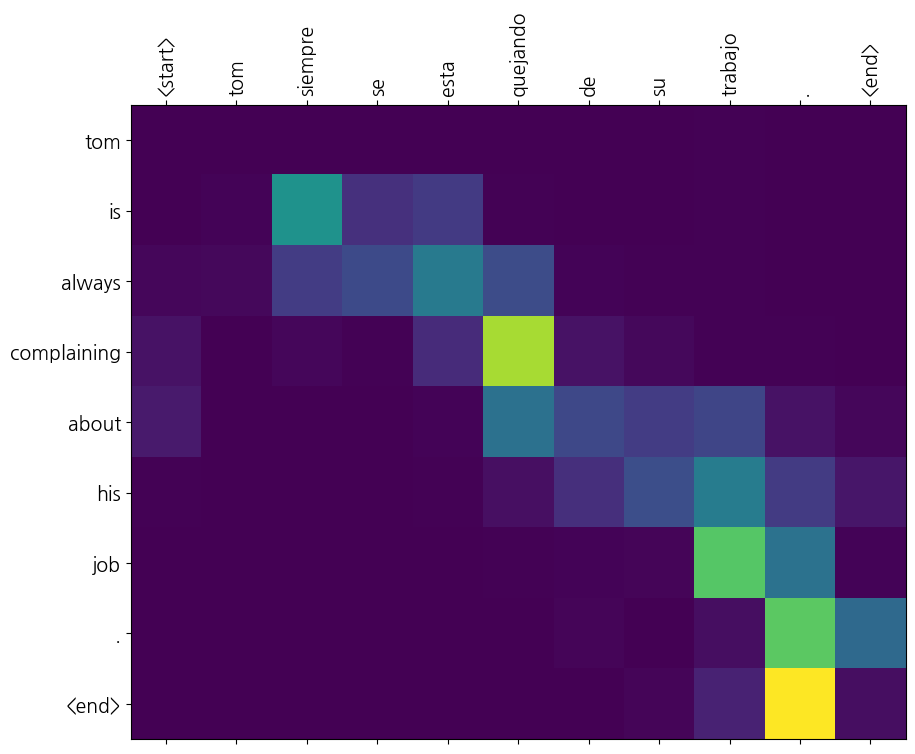

In [23]:
translate(u'tom siempre se esta quejando de su trabajo .')

Input : <start> la mama se quedo en el coche mientras papa iba de compras . <end>
Predicted translation : mom remained in the car while dad shopped . <end> 


C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


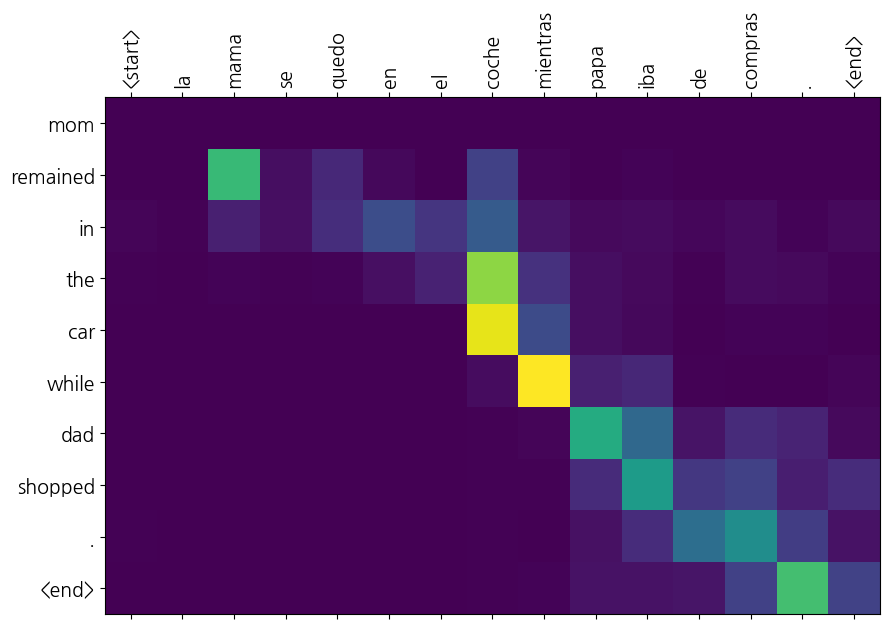

In [24]:
translate(u'la mama se quedo en el coche mientras papa iba de compras .')

Input : <start> por lo general , vale la pena jugar el juego de la vida . <end>
Predicted translation : generally speaking , the world will be eaten the game on life . <end> 


C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Myeong\AppData\Local\Temp\ipykernel_14532\3724270038.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


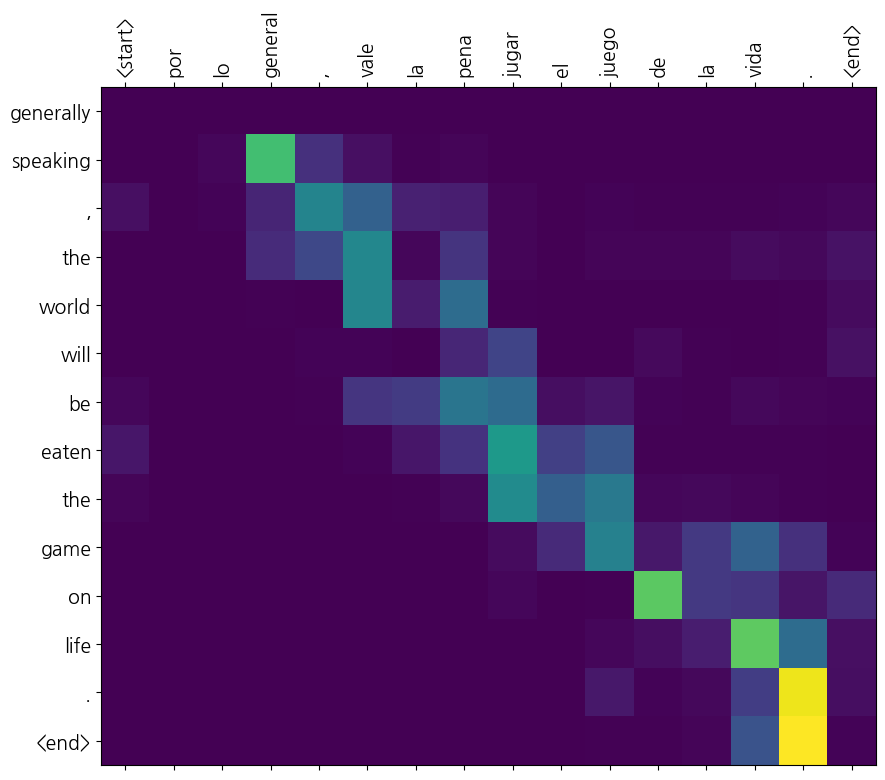

In [25]:
translate(u'por lo general , vale la pena jugar el juego de la vida .')